In [1]:
!pip install tensorflow==2.16.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.16.1


# The Auto MPG Dataset

In [3]:
# Get the data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

In [4]:
# Load the dataset
raw_dataset = pd.read_csv(url, names=column_names,
    na_values='?', comment='\t',
    sep=' ', skipinitialspace=True)

In [5]:
# Make a copy of the dataset
data = raw_dataset.copy()
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


# Clean the data

In [6]:
# Check the unknowns values
data.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# Drop rows with missing values
data = data.dropna()

In [8]:
# Map 'Origin' column to country names
data['Origin'] = data['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [9]:
# Convert categorical 'Origin' column to one-hot encoding
data = pd.get_dummies(data, columns=['Origin'], prefix='', prefix_sep='')
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,False,False,True
1,15.0,8,350.0,165.0,3693.0,11.5,70,False,False,True
2,18.0,8,318.0,150.0,3436.0,11.0,70,False,False,True
3,16.0,8,304.0,150.0,3433.0,12.0,70,False,False,True
4,17.0,8,302.0,140.0,3449.0,10.5,70,False,False,True


# Split the data into training and test sets

In [10]:
# Sample 80% of the data for training
train_dataset = data.sample(frac=0.8, random_state=0)

# Sample the remaining 20% for testing
test_dataset = data.drop(train_dataset.index)

# Inspect the data

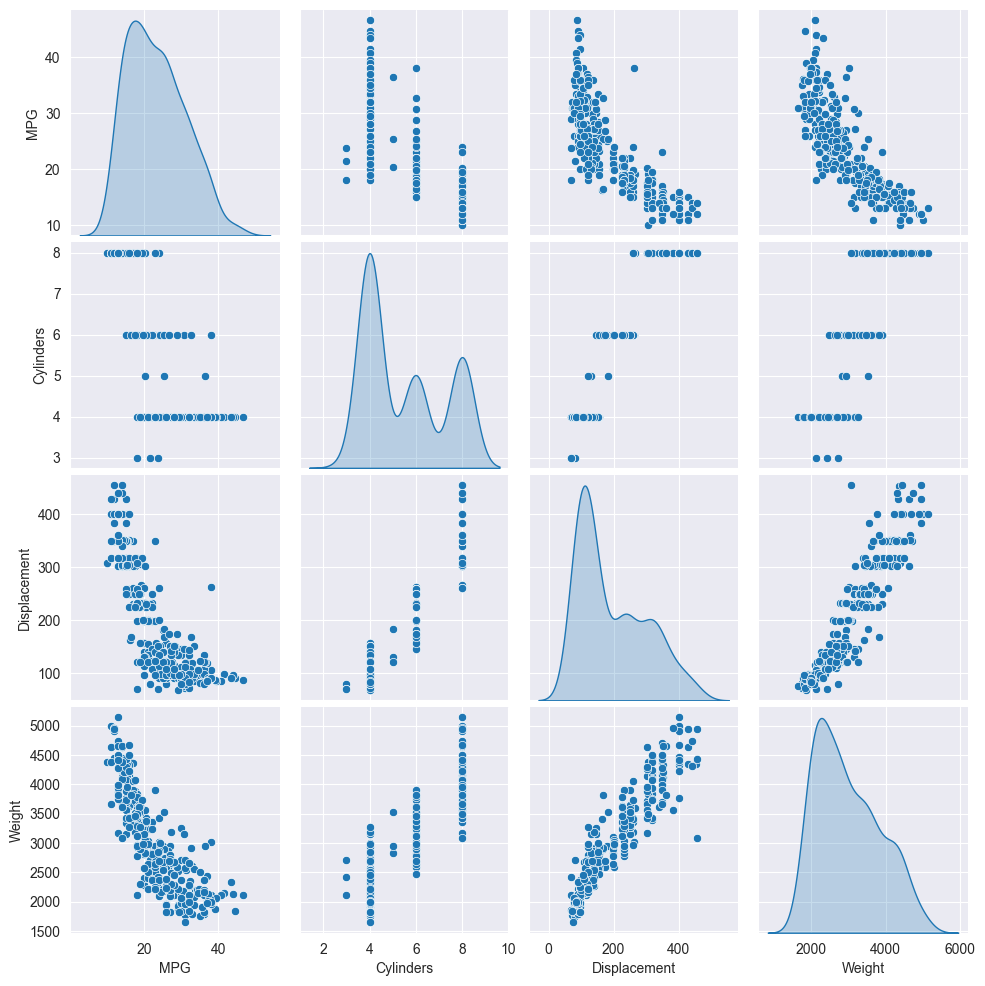

In [11]:
# Create pair plots of selected features
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
# Display summary statistics of the training dataset
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


# Split features from labels

In [13]:
# Separate the 'MPG' column as labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalization

In [14]:
# Display mean and standard deviation of the training dataset
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


# The Normalization layer

In [15]:
# Create a normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [16]:
# Adapt the normalizer to the training features
normalizer.adapt(np.array(train_features))

In [17]:
# Display the mean values after normalization
print(normalizer.mean.numpy())

[[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
  7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]]


In [18]:
# Example of the first row before and after normalization
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[4 90.0 75.0 2125.0 14.5 74 False False True]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear regression

In [19]:
# Extract 'Horsepower' column as numpy array
horsepower = np.array(train_features['Horsepower'])

# Create a normalization layer for "Horsepower"
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [20]:
# Build a linear regression model for "Horsepower"
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

# Display model summary
horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [21]:
# Predict the first 10 values of 'Horsepower'
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


array([[-0.788094  ],
       [-0.44509375],
       [ 1.4545999 ],
       [-1.1047095 ],
       [-0.999171  ],
       [-0.39232445],
       [-1.1838635 ],
       [-0.999171  ],
       [-0.2604013 ],
       [-0.44509375]], dtype=float32)

In [22]:
# Compile the model with Adam optimizer and mean absolute error loss
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [23]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 734 ms
Wall time: 3.91 s


In [24]:
# Convert training history to DataFrame and display the last few rows
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804100,4.196377,95
96,3.804388,4.170066,96
97,3.804789,4.192737,97
98,3.806029,4.186537,98
99,3.805063,4.186685,99


In [25]:
# Function to plot training loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

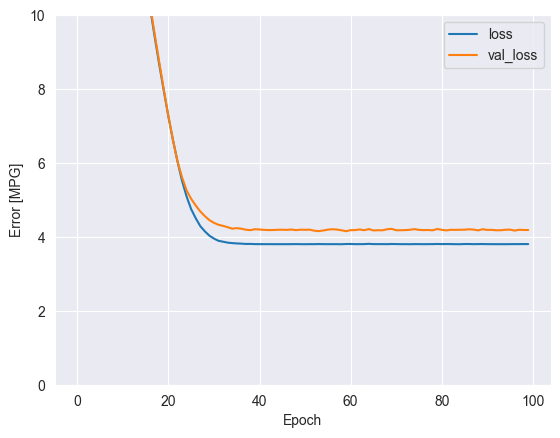

In [26]:
plot_loss(history)

In [27]:
# Evaluate the model on the test set
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [28]:
# Generate predictions for a range of 'Horsepower' values
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [29]:
# Function to plot 'Horsepower' vs 'MPG' predictions
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

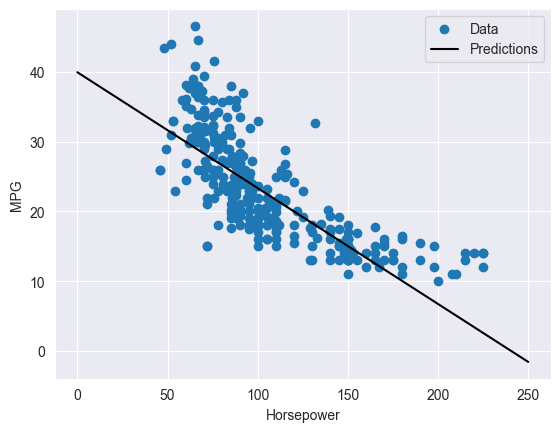

In [30]:
plot_horsepower(x, y)

# Linear regression with multiple inputs

In [31]:
# Build a linear regression model with multiple inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [32]:
# Predict the first 10 examples
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[-0.03951916],
       [-0.6270107 ],
       [-0.7277944 ],
       [-0.80660474],
       [ 1.5341871 ],
       [-0.4716245 ],
       [ 1.6251758 ],
       [ 0.8536931 ],
       [-0.03496177],
       [ 2.046688  ]], dtype=float32)

In [33]:
# Display the kernel (weights) of the dense layer
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_1/dense_1/kernel>

In [34]:
# Compile the model
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 344 ms
Wall time: 3.75 s


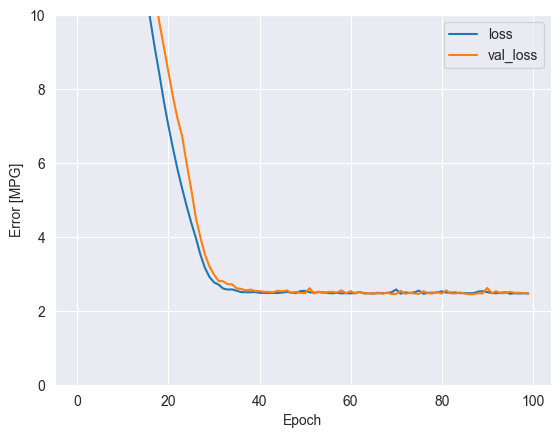

In [36]:
# Plot training loss
plot_loss(history)

In [37]:
# Evaluate the model on the test set
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Regression with a deep neural network (DNN)

In [38]:
# Function to build and compile a DNN model
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Regression using a DNN and a single input

In [39]:
# Build and compile a DNN model for 'Horsepower'
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [40]:
# Display model summary
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [41]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 1.34 s
Wall time: 4.07 s


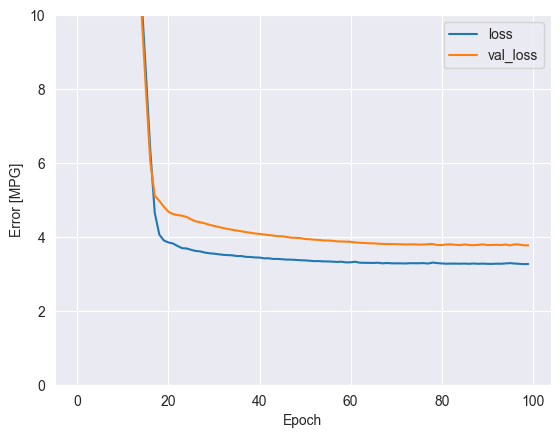

In [42]:
# Plot training loss
plot_loss(history)

In [43]:
# Generate predictions for a range of 'Horsepower' values
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B852DC19E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


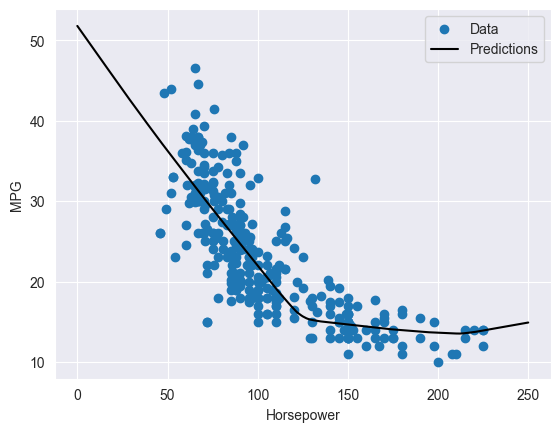

In [44]:
# Plot 'Horsepower' vs 'MPG' predictions
plot_horsepower(x, y)

In [45]:
# Evaluate the model on the test set
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

# Regression using a DNN and multiple inputs

In [46]:
# Build and compile a DNN model with multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [47]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 938 ms
Wall time: 4.11 s


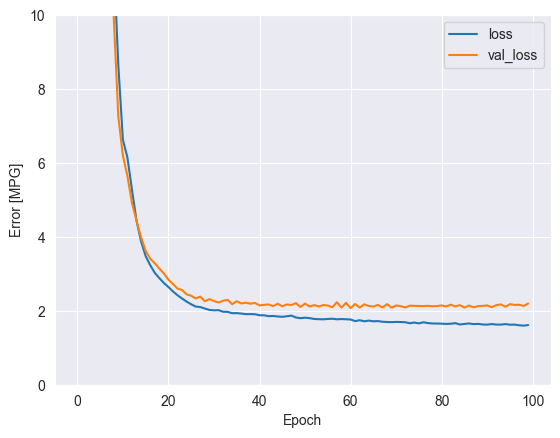

In [48]:
# Plot training loss
plot_loss(history)

In [49]:
# Evaluate the model on the test set
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Performance

In [50]:
# Display the test results as a DataFrame
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.660023
linear_model,2.479414
dnn_horsepower_model,2.924603
dnn_model,1.705045


# Make predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


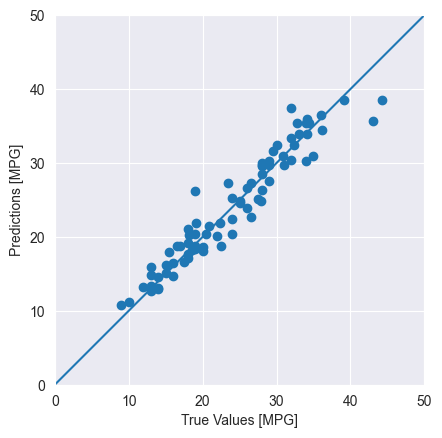

In [51]:
# Predict MPG values for the test set
test_predictions = dnn_model.predict(test_features).flatten()

# Plot true vs predicted MPG values
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

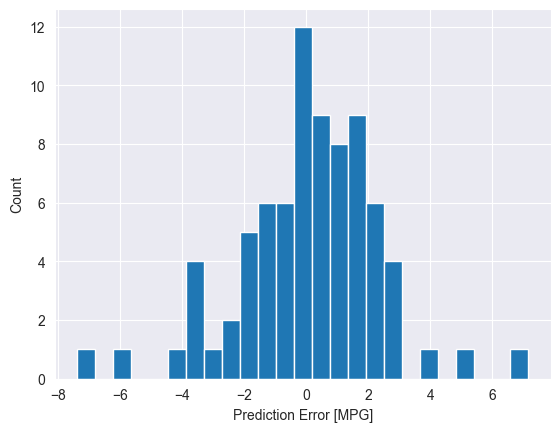

In [52]:
# Plot prediction error histogram
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [53]:
# Save the DNN model
dnn_model.save('dnn_model.keras')

In [62]:
# Load the saved model
reloaded = tf.keras.models.load_model('dnn_model.keras')

ValueError: A total of 1 objects could not be loaded. Example error message for object <keras.src.optimizers.adam.Adam object at 0x000001B854496BA0>:

'Unable to synchronously open object (bad object header version number)'

List of objects that could not be loaded:
[<keras.src.optimizers.adam.Adam object at 0x000001B854496BA0>]

In [63]:
# Evaluate the reloaded model on the test set
test_results['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose=0)

NameError: name 'reloaded' is not defined

In [ ]:
# Display the final test results
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T